In [2]:
!pip install transformers datasets tokenizers seqeval -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.5 MB/s eta 0:00:00


In [3]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.8 MB/s eta 0:00:00


In [4]:
!pip install accelerate -U

In [5]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd drive/MyDrive/work

/content/drive/MyDrive/work


In [8]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import datasets
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertConfig
from transformers import DataCollatorForTokenClassification
from transformers import BertForTokenClassification, AdamW


import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [9]:
data = pd.read_csv("data/ner_dataset1.csv", encoding = "ISO-8859-1")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [10]:
tag_map = {'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-per': 3, 'I-geo': 4, 'B-org': 5, 'I-org': 6, 'B-tim': 7, 'B-art': 8, 'I-art': 9, 'I-per': 10, 'I-gpe': 11, 'I-tim': 12, 'B-nat': 13, 'B-eve': 14, 'I-eve': 15, 'I-nat': 16}

In [11]:
data = data.fillna(method = 'ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [12]:
entities_to_remove = ["B-gpe","I-gpe","B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat"]
data = data[~data.Tag.isin(entities_to_remove)]
data =data.drop(['POS'],axis=1)
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [13]:
data['Sentence #'] = LabelEncoder().fit_transform(data['Sentence #'])
data.head()

,Sentence #,Word,Tag
0,0,Thousands,O
1,0,of,O
2,0,demonstrators,O
3,0,have,O
4,0,marched,O


In [14]:
class GetSentence(object):
    def __init__(self,data):
        self.data = data
        self.n_sentences = 1
        self.empty = False
        agg_function = lambda s: [(w,t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.group = self.data.groupby('Sentence #').apply(agg_function)
        self.sentence = [s for s in self.group]

In [15]:
getter = GetSentence(data)

In [16]:
sentence = [[word[0] for word in sentence] for sentence in getter.sentence]

In [17]:
sentence[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [18]:
labels = [[lab[1] for lab in sentence] for sentence in getter.sentence]

In [19]:
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [20]:
tag_values = list(set(data["Tag"].values))

In [21]:
tag_values

['O', 'B-org', 'B-geo', 'B-per', 'I-org', 'I-per', 'I-geo', 'B-tim', 'I-tim']

In [22]:
tag_values.append('PAD')

In [23]:
tag_idx = {t: i for i, t in enumerate(tag_values)}

In [24]:
tag_idx

{'O': 0,
 'B-org': 1,
 'B-geo': 2,
 'B-per': 3,
 'I-org': 4,
 'I-per': 5,
 'I-geo': 6,
 'B-tim': 7,
 'I-tim': 8,
 'PAD': 9}

In [25]:
torch.__version__

'2.1.0+cu118'

In [26]:
MAX_LEN = 75
BATCH_SIZE = 32

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
print(torch.cuda.device_count())

1


In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

In [30]:
def tokenize_preserve(sentences,text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentences,text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label]*n_subwords)

    return tokenized_sentence, labels

In [31]:
tokenized_texts_and_labels = [
  tokenize_preserve(sent,labs)
  for sent,labs in zip(sentence,labels)
]

In [32]:
tokenized_text = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1]for token_label_pair in tokenized_texts_and_labels]

In [33]:
len(tokenized_text[0]) , len(labels[0])

(25, 25)

In [34]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_text],
                         maxlen=MAX_LEN, dtype='long',value=0.0,
                         truncating='post',padding='post')

In [35]:
tags = pad_sequences([[tag_idx.get(l)for l in lab]for lab in labels],
                    maxlen=MAX_LEN, dtype='long', value=tag_idx['PAD'],
                    truncating='post',padding='post')

In [36]:
attention_masks = [[float(i !=0.0)for i in ii]for ii in input_ids]

In [37]:
trt_input, val_input, trt_tag, val_tag = train_test_split(input_ids,tags,random_state=42,test_size=.1)
trt_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=.1)

tr_input, test_input, tr_tag, test_tag = train_test_split(trt_input,trt_tag,random_state=42,test_size=.1)
tr_masks, test_masks, _, _ = train_test_split(trt_masks, trt_input, random_state=42, test_size=.1)

In [38]:
tr_input.shape, val_input.shape, test_input.shape,

((38846, 75), (4796, 75), (4317, 75))

In [39]:
len(tr_masks[0]), len(tr_input[0]), len(tr_tag[0]), len(test_input[0]), len(test_masks[0]), len(test_tag[0])

(75, 75, 75, 75, 75, 75)

In [40]:
print(tr_masks[0]), print(tr_input[0]), print(tr_tag[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[26159  1104  1105  2222  1106  2519 14466  1296  1214  1106  3359  5224
  1107  1147  1313  2182   119     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[0 0 0 0 0 0 2 7 0 0 0 0 0 0 0 0 0 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9]


(None, None, None)

In [41]:
tr_input = torch.tensor(tr_input)
val_input = torch.tensor(val_input)
tr_tag = torch.tensor(tr_tag)
val_tag = torch.tensor(val_tag)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
test_input = torch.tensor(test_input)
test_tag = torch.tensor(test_tag)
test_masks = torch.tensor(test_masks)

In [42]:
train_data = TensorDataset(tr_input, tr_masks, tr_tag)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(tr_input, tr_masks, tr_tag)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(test_input, test_masks, test_tag)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [43]:
model = BertForTokenClassification.from_pretrained(
'bert-base-cased',
num_labels=len(tag_idx),
output_attentions = False,
output_hidden_states = False)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [45]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [46]:
from transformers import get_linear_schedule_with_warmup

epochs = 7
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [47]:
!pip install seqeval

In [48]:
from seqeval.metrics import f1_score, accuracy_score, classification_report

In [49]:
from tqdm import tqdm, trange

In [50]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [51]:
#storing loss values
loss_values, validation_loss_values = [], []

#TRAINING AND VALIDATION

for _ in trange(epochs, desc= "Epoch"):
    #/|\==>TRAINLOOP(ONEPASS)<==\|/
    model.train()
    total_loss=0 #so it resets each epoch

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch #also the order in train_data/val_data

        model.zero_grad() #clearing previous gradients for each epoch

        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask, labels=b_labels)#forward pass

        loss = outputs[0]
        loss.backward() #getting the loss and performing backward pass

        total_loss += loss.item() #tracking loss

        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        #^^^ preventing exploding grads

        optimizer.step() #updates parameters

        scheduler.step() #update learning_rate

    avg_train_loss = total_loss/len(train_dataloader)
    print('Average train loss : {}'.format(avg_train_loss))

    loss_values.append(avg_train_loss) #storing loss values if you choose to plot learning curve

    #/|\==>VALIDATION(ONEPASS)<==\|/
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []

    for batch in valid_dataloader:
        batch = tuple(t.to(device)for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids =None,
                           attention_mask=b_input_mask, labels=b_labels)

        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)

    print('Validation loss: {}'.format(eval_loss))

    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                for p_i, l_i, in zip(p,l)if tag_values[l_i] !='PAD']

    valid_tags = [tag_values[l_i]for l in true_labels
                 for l_i in l if tag_values[l_i] !='PAD']

    print('Validation Accuracy: {}'.format(accuracy_score(pred_tags,valid_tags)))
    print('Validation F-1 Score:{}'.format(f1_score([pred_tags], [valid_tags])))
    print('Validation Classification Report:{}'.format(classification_report([pred_tags], [valid_tags])))
    print()

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Average train loss : 0.06998963164444859
Validation loss: 0.033052541298678226
Validation Accuracy: 0.9672203228800795


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Validation F-1 Score:0.8367941218795764


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  14%|█▍        | 1/7 [10:52<1:05:16, 652.76s/it]

Validation Classification Report:              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         1
         geo       0.90      0.87      0.89     49819
         org       0.71      0.79      0.75     25799
         per       0.84      0.79      0.82     23700
         tim       0.85      0.86      0.85     18659

   micro avg       0.84      0.84      0.84    117978
   macro avg       0.66      0.66      0.66    117978
weighted avg       0.84      0.84      0.84    117978


Average train loss : 0.03379677834919051
Validation loss: 0.022831896085620442
Validation Accuracy: 0.9766275237025079
Validation F-1 Score:0.8742766698322254


Epoch:  29%|██▊       | 2/7 [21:37<53:59, 647.94s/it]  

Validation Classification Report:              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         2
         geo       0.96      0.86      0.91     53267
         org       0.75      0.87      0.80     24556
         per       0.86      0.86      0.86     22416
         tim       0.88      0.91      0.90     18396

   micro avg       0.88      0.87      0.87    118637
   macro avg       0.69      0.70      0.69    118637
weighted avg       0.88      0.87      0.88    118637


Average train loss : 0.024802390947827494
Validation loss: 0.015199334748454477
Validation Accuracy: 0.9836460231448324
Validation F-1 Score:0.9075588810475299


Epoch:  43%|████▎     | 3/7 [32:19<43:00, 645.23s/it]

Validation Classification Report:              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         1
         geo       0.92      0.95      0.93     46622
         org       0.87      0.87      0.87     28861
         per       0.88      0.89      0.89     22237
         tim       0.93      0.92      0.92     19211

   micro avg       0.90      0.91      0.91    116932
   macro avg       0.72      0.73      0.72    116932
weighted avg       0.90      0.91      0.91    116932


Average train loss : 0.01808093676015219
Validation loss: 0.010250411619113135
Validation Accuracy: 0.9894535403818387
Validation F-1 Score:0.938330737825666


Epoch:  57%|█████▋    | 4/7 [43:01<32:12, 644.18s/it]

Validation Classification Report:              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         2
         geo       0.98      0.93      0.96     50532
         org       0.90      0.92      0.91     27944
         per       0.91      0.94      0.93     21883
         tim       0.95      0.95      0.95     18941

   micro avg       0.94      0.93      0.94    119302
   macro avg       0.75      0.75      0.75    119302
weighted avg       0.94      0.93      0.94    119302


Average train loss : 0.013049713839183038
Validation loss: 0.0071821667748208804
Validation Accuracy: 0.9926956463890382
Validation F-1 Score:0.9571666708975368


Epoch:  71%|███████▏  | 5/7 [53:46<21:28, 644.32s/it]

Validation Classification Report:              precision    recall  f1-score   support

         geo       0.98      0.96      0.97     48664
         org       0.93      0.94      0.94     28185
         per       0.94      0.95      0.94     22334
         tim       0.97      0.97      0.97     18887

   micro avg       0.96      0.96      0.96    118070
   macro avg       0.95      0.96      0.96    118070
weighted avg       0.96      0.96      0.96    118070


Average train loss : 0.009732523695044097
Validation loss: 0.004737145708323628
Validation Accuracy: 0.9955635433027487
Validation F-1 Score:0.9722928295768345


Epoch:  86%|████████▌ | 6/7 [1:04:27<10:43, 643.35s/it]

Validation Classification Report:              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         1
         geo       0.99      0.97      0.98     49084
         org       0.95      0.97      0.96     28027
         per       0.96      0.97      0.96     22366
         tim       0.98      0.98      0.98     19068

   micro avg       0.97      0.97      0.97    118546
   macro avg       0.78      0.78      0.78    118546
weighted avg       0.97      0.97      0.97    118546


Average train loss : 0.007589418764747419
Validation loss: 0.004152270390801139
Validation Accuracy: 0.9960801597457042
Validation F-1 Score:0.9754561342778261


Epoch: 100%|██████████| 7/7 [1:15:13<00:00, 644.74s/it]

Validation Classification Report:              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         1
         geo       0.99      0.97      0.98     49103
         org       0.95      0.98      0.96     27950
         per       0.97      0.97      0.97     22469
         tim       0.98      0.98      0.98     19071

   micro avg       0.98      0.97      0.98    118594
   macro avg       0.78      0.78      0.78    118594
weighted avg       0.98      0.97      0.98    118594




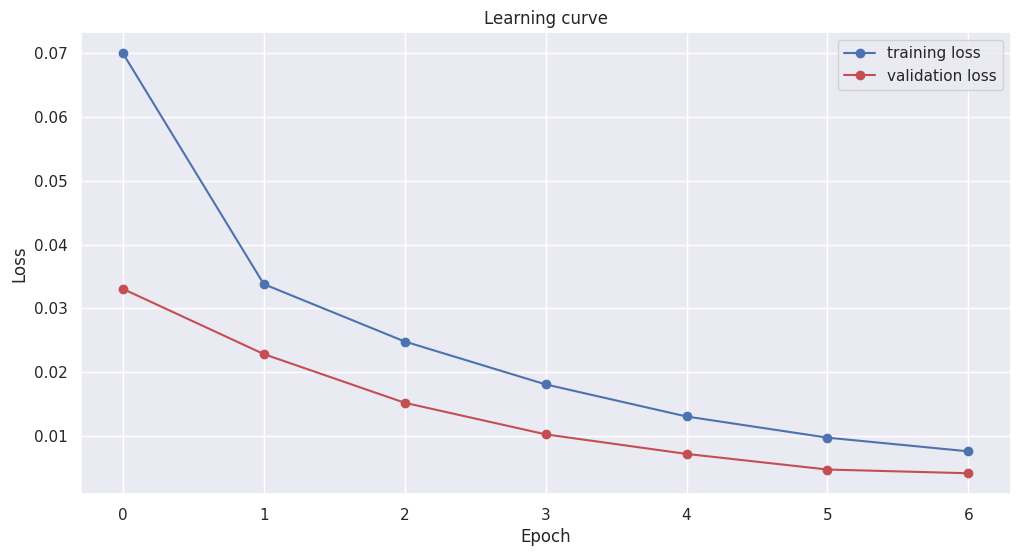

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [53]:
model.eval()

predictions, true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask, labels=b_labels)

    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
            for p_i, l_i in zip(p,l) if tag_values[l_i] != 'PAD']

valid_tags = [tag_values[l_i] for l in true_labels
                for l_i in l if tag_values[l_i] != 'PAD']

print('Test Accuracy: {}'.format(accuracy_score(pred_tags, valid_tags)))
print('Test F-1 Score: {}'.format(f1_score([pred_tags], [valid_tags])))
print('Test Classification Report: {}'.format(classification_report([pred_tags], [valid_tags])))

Test Accuracy: 0.9665580103827116
Test F-1 Score: 0.841622206469425
Test Classification Report:               precision    recall  f1-score   support

         geo       0.91      0.88      0.89      5811
         org       0.74      0.75      0.75      3077
         per       0.81      0.81      0.81      2453
         tim       0.88      0.88      0.88      2140

   micro avg       0.85      0.84      0.84     13481
   macro avg       0.83      0.83      0.83     13481
weighted avg       0.85      0.84      0.84     13481



In [55]:
os.getcwd()

'/content/drive/MyDrive/work'

In [56]:
## Save model
import os
PATH = os.path.join(os.getcwd(), 'ner_model_pretrained_bert.pth')
TOKENIZER_PATH = os.path.join(os.getcwd(), 'ner_tokenizer')
print(PATH)
print(TOKENIZER_PATH)

/content/drive/MyDrive/work/ner_model_pretrained_bert.pth
/content/drive/MyDrive/work/ner_tokenizer


In [59]:
# model.save_pretrained(PATH)
torch.save(model, PATH)

In [58]:
## Save tokenizer
tokenizer.save_pretrained(TOKENIZER_PATH)

('/content/drive/MyDrive/work/ner_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/work/ner_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/work/ner_tokenizer/vocab.txt',
 '/content/drive/MyDrive/work/ner_tokenizer/added_tokens.json')

In [60]:
import json

In [61]:
id2label = {
    str(i): label for i,label in enumerate(tag_values)
}
label2id = {
    label: str(i) for i,label in enumerate(tag_values)
}

In [63]:
# config = json.load(open("ner_model_pretrained_bert/config.json"))
# config["id2label"] = id2label
# config["label2id"] = label2id
# json.dump(config, open("ner_model_pretrained_bert/config.json","w"))

In [64]:
# model_fine_tuned = BertForTokenClassification.from_pretrained(PATH)
model_fine_tuned = torch.load(PATH)
model_fine_tuned = model_fine_tuned.to(device)

In [70]:
tokenizer_bert = BertTokenizer.from_pretrained(TOKENIZER_PATH)

In [71]:
test_sentence = """Huy and Tuong were running in the forest with their dog last month in Da Nang city"""

In [72]:
tokenized_sentence = tokenizer_bert.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [73]:
with torch.no_grad():
    output = model_fine_tuned(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(),axis=2)

In [74]:
tokens = tokenizer_bert.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith('##'):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [76]:
names = []
locs = []
tims = []

curr_name = ""
curr_loc = ""
curr_tim = ""
for i in range(len(new_tokens)):
    if new_labels[i] != 'O':
        leb = new_labels[i]
        # print(curr_loc)
        if leb == "B-per":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_name != "":
                curr_name += " "
            curr_name += new_tokens[i]


        if leb == "I-per":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_name != "":
                curr_name += " "
            curr_name += new_tokens[i]

        if leb == "B-geo":
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_loc != "":
                curr_loc += " "
            curr_loc += new_tokens[i]

        if leb == "I-geo":
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_loc != "":
                curr_loc += " "
            curr_loc += new_tokens[i]

        if leb == "B-org":
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_loc != "":
                curr_loc += " "
            curr_loc += new_tokens[i]



        if leb == "I-org":
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_tim != "":
                tims.append(curr_tim)
                curr_tim = ""
            if curr_loc != "":
                curr_loc += " "
            curr_loc += new_tokens[i]

        if leb == "B-tim":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_tim != "":
                curr_tim += " "
            curr_tim += new_tokens[i]

        if leb == "I-tim":
            if curr_loc != "":
                locs.append(curr_loc)
                curr_loc = ""
            if curr_name != "":
                names.append(curr_name)
                curr_name = ""
            if curr_tim != "":
                curr_tim += " "
            curr_tim += new_tokens[i]
    else:
        if curr_name != "":
            names.append(curr_name)
            curr_name = ""
        if curr_loc != "":
            locs.append(curr_loc)
            curr_loc = ""
        if curr_tim != "":
            tims.append(curr_tim)
            curr_tim = ""

df = pd.DataFrame()
df["Free flow of Text"] = [test_sentence]
df["Extracted Name"] = [list(set(names))]
df["Extracted Location"] = [locs]
df["Extracted Time"] = [tims]

In [77]:
df

,Free flow of Text,Extracted Name,Extracted Location,Extracted Time
0,Huy and Tuong were running in the forest with ...,"[Tuong, Huy]",[Da Nang],[last month]


In [ ]:
# import pickle

# # saving
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)